In [1]:
#from tyxe_runfiles import train, generate, eval
from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyro

In [2]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "sinus-(10,20)-normal"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-1k ======


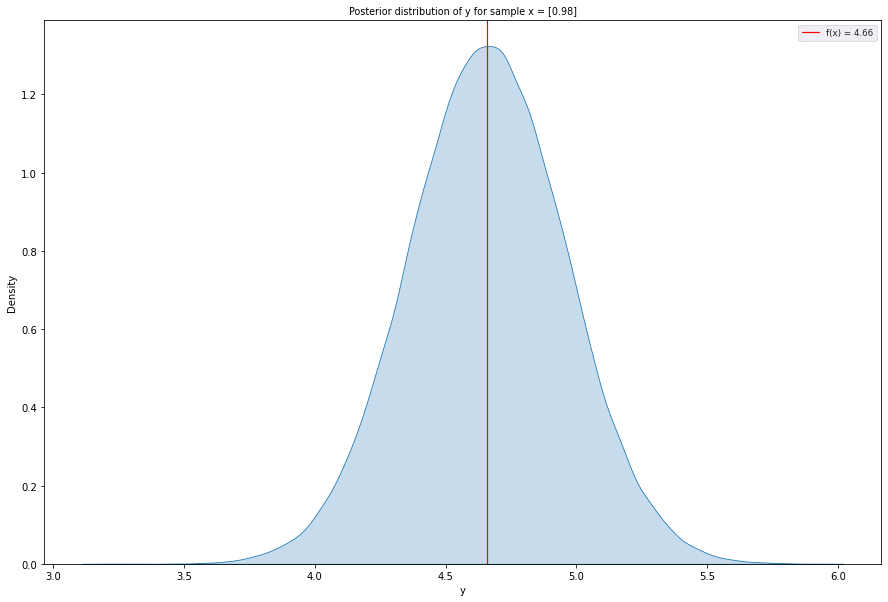

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

(1000, 2)
torch.Size([1000, 1]) torch.Size([1000])


In [6]:
x_train.shape, y_train.shape

(torch.Size([1000, 1]), torch.Size([1000]))

In [7]:
x_test[0], y_test[0]

(tensor([-7.8232]), tensor(1.6878))

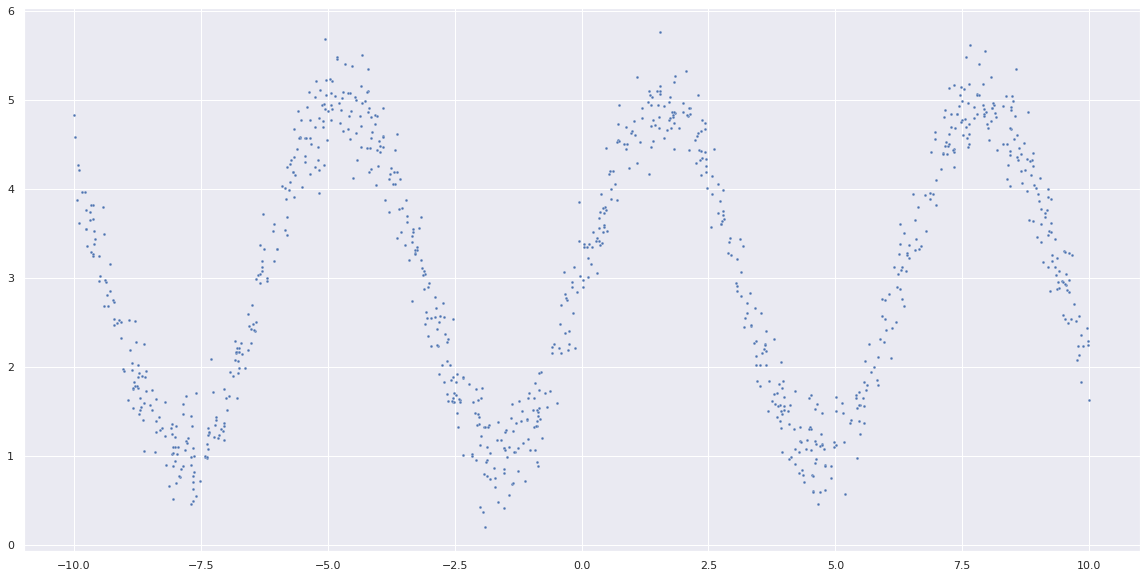

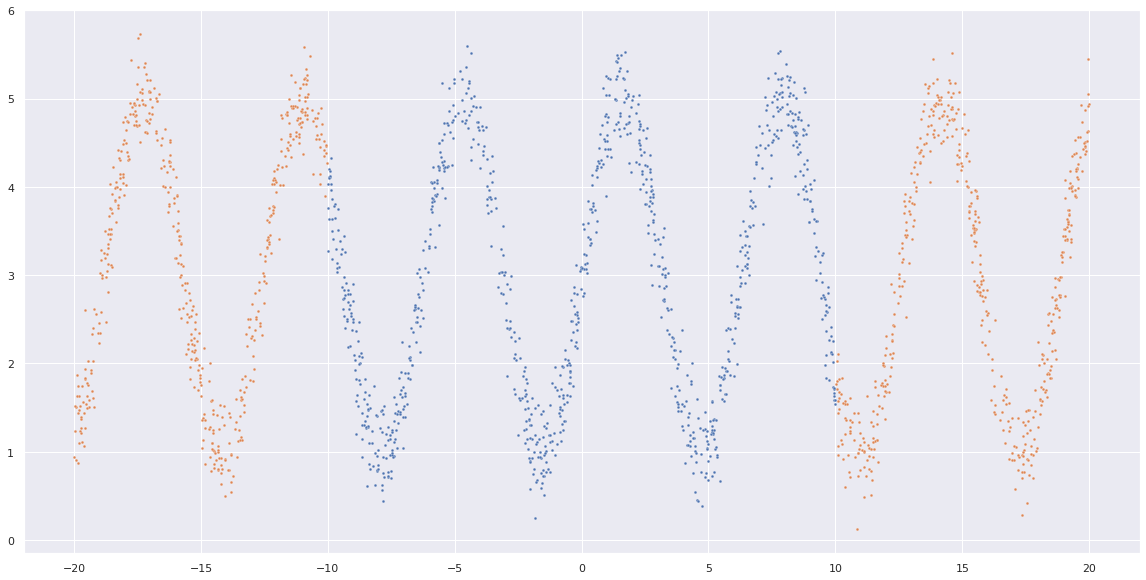

In [8]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_train.flatten(), y=y_train.flatten(), s=8, ax=ax)
plt.show()
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_test_in_domain.flatten(), y=y_test_in_domain.flatten(), s=8, ax=ax)
sns.scatterplot(x=x_test_out_domain.flatten(), y=y_test_out_domain.flatten(), s=8, ax=ax)
plt.show()


In [9]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    bnn = train.train(config, dataset_config, f"{BASE_DIR}")

(1000, 2)
torch.Size([1000, 1]) torch.Size([1000])
AutoNormal()
Using device: cpu
===== Training profile sinus-(10,20)-normal =====


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training finished in 0:00:07.619633 seconds


In [10]:
predictive = bnn.get_predictive(num_predictions=500)
#train_samples = bnn.predict(x_train, num_predictions=10, aggregate=False)
#train_samples.keys()
test_samples = predictive(x_test)
train_samples = predictive(x_train)
test_samples["obs"][0]


tensor([ 4.5748e-01,  1.1907e+00,  8.9343e-01,  1.9575e-01, -2.1734e-01,
         1.6121e+00,  3.6602e-01,  1.6939e+00, -2.3890e-02,  4.2028e-01,
         4.9232e-01,  2.5002e+00, -2.3111e-01,  2.1602e-01,  2.1058e+00,
         2.5235e-01,  2.3431e+00,  5.3384e-01,  6.2378e-01,  1.2027e+00,
         2.2290e+00,  7.8323e-01,  8.4709e-01,  2.5736e-01,  9.6516e-01,
         6.6534e-01,  1.4975e+00,  1.1811e+00,  1.2523e+00,  4.7926e-01,
         5.9363e-01,  1.4185e+00,  1.4951e+00,  5.8916e-01,  5.0171e-01,
        -2.2728e-01,  2.3372e+00,  4.4260e-01,  2.1232e+00,  1.0348e+00,
         8.6378e-01,  1.9247e+00,  1.5946e+00, -3.4719e-02,  1.0797e+00,
         2.9219e-01, -2.7424e-01,  1.5391e+00,  1.9453e+00, -1.0652e-01,
         1.6767e+00,  9.1268e-01,  2.3942e+00,  1.3547e+00,  7.1444e-01,
         9.0073e-01,  8.2374e-01,  1.9510e-01,  3.1091e-01,  1.5715e+00,
         1.8808e+00, -4.9711e-01,  2.1654e-01,  3.4835e-01,  1.4206e+00,
        -5.1779e-01,  6.0559e-01,  2.2086e+00,  2.1

In [11]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        print(k, v.shape)
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v[0]) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v[0]) * 0.95), dim=0)[0],
        }
    return site_stats

train_pred_summary = summary(train_samples)
test_pred_summary = summary(test_samples)

obs torch.Size([100, 1000])


RuntimeError: kthvalue(): selected number k out of range for dimension 0

In [ ]:
train_y = train_pred_summary["obs"]
train_mu = train_pred_summary["_RETURN"]
train_predictions = pd.DataFrame({
    "x": x_train.flatten(),
    "mu": train_mu["mean"].flatten(),
    "mu_5": train_mu["5%"].flatten(),
    "mu_95": train_mu["95%"].flatten(),
    "y_mean": train_y["mean"].flatten(),
    "y_5": train_y["5%"].flatten(),
    "y_95": train_y["95%"].flatten(),
    "true_y": y_train.flatten()
})

test_y = test_pred_summary["obs"]
test_mu = test_pred_summary["_RETURN"]
test_predictions = pd.DataFrame({
    "x": x_test.flatten(),
    "mu": test_mu["mean"].flatten(),
    "mu_5": test_mu["5%"].flatten(),
    "mu_95": test_mu["95%"].flatten(),
    "y_mean": test_y["mean"].flatten(),
    "y_5": test_y["5%"].flatten(),
    "y_95": test_y["95%"].flatten(),
    "true_y": y_test.flatten()
})


ValueError: All arrays must be of the same length

In [ ]:
train_predictions.head()

,x,mu,y_mean,true_y
0,0.976270,0.131781,-0.001537,4.626319
1,4.303787,0.328988,0.491933,1.170429
2,2.055268,0.191694,0.468164,5.324720
3,0.897664,0.127810,0.160546,4.499495
4,-1.526904,0.122631,0.186739,0.852221


In [ ]:
train_pred_sorted = train_predictions.sort_values(by='x')
test_pred_sorted = test_predictions.sort_values(by='x')

def plot_predictions(summary, SAVE_PATH=None):
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['mu'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['mu_5'], y2=summary['mu_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)
    
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['y_mean'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['y_5'], y2=summary['y_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)

    if SAVE_PATH:
        plt.savefig(SAVE_PATH)

KeyError: 'mu_5'

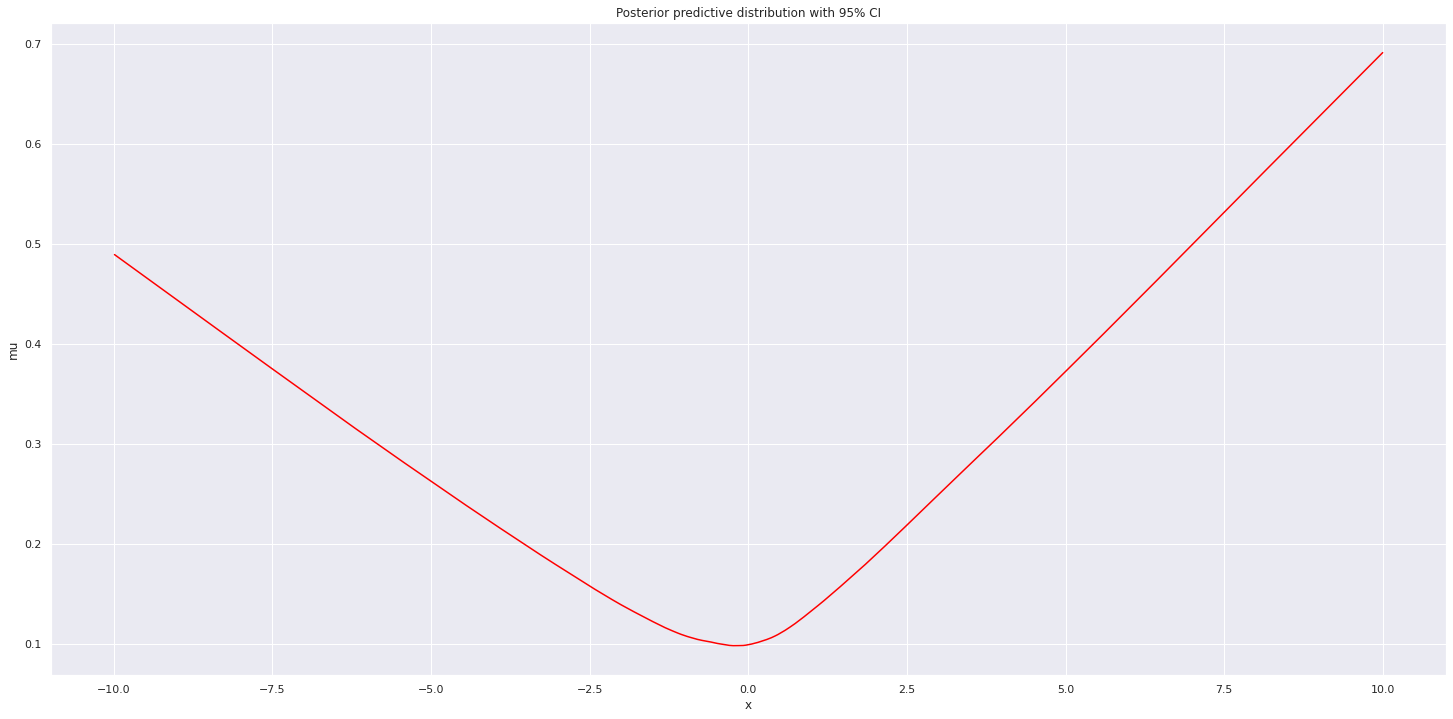

In [ ]:
plot_predictions(train_pred_sorted, SAVE_PATH=f"{BASE_DIR}/1d_train_predictions.png")
plot_predictions(test_pred_sorted, SAVE_PATH=f"{BASE_DIR}/1d_test_predictions.png")

using device: cpu
====== evaluating profile sinus-(10,20)-normal ======


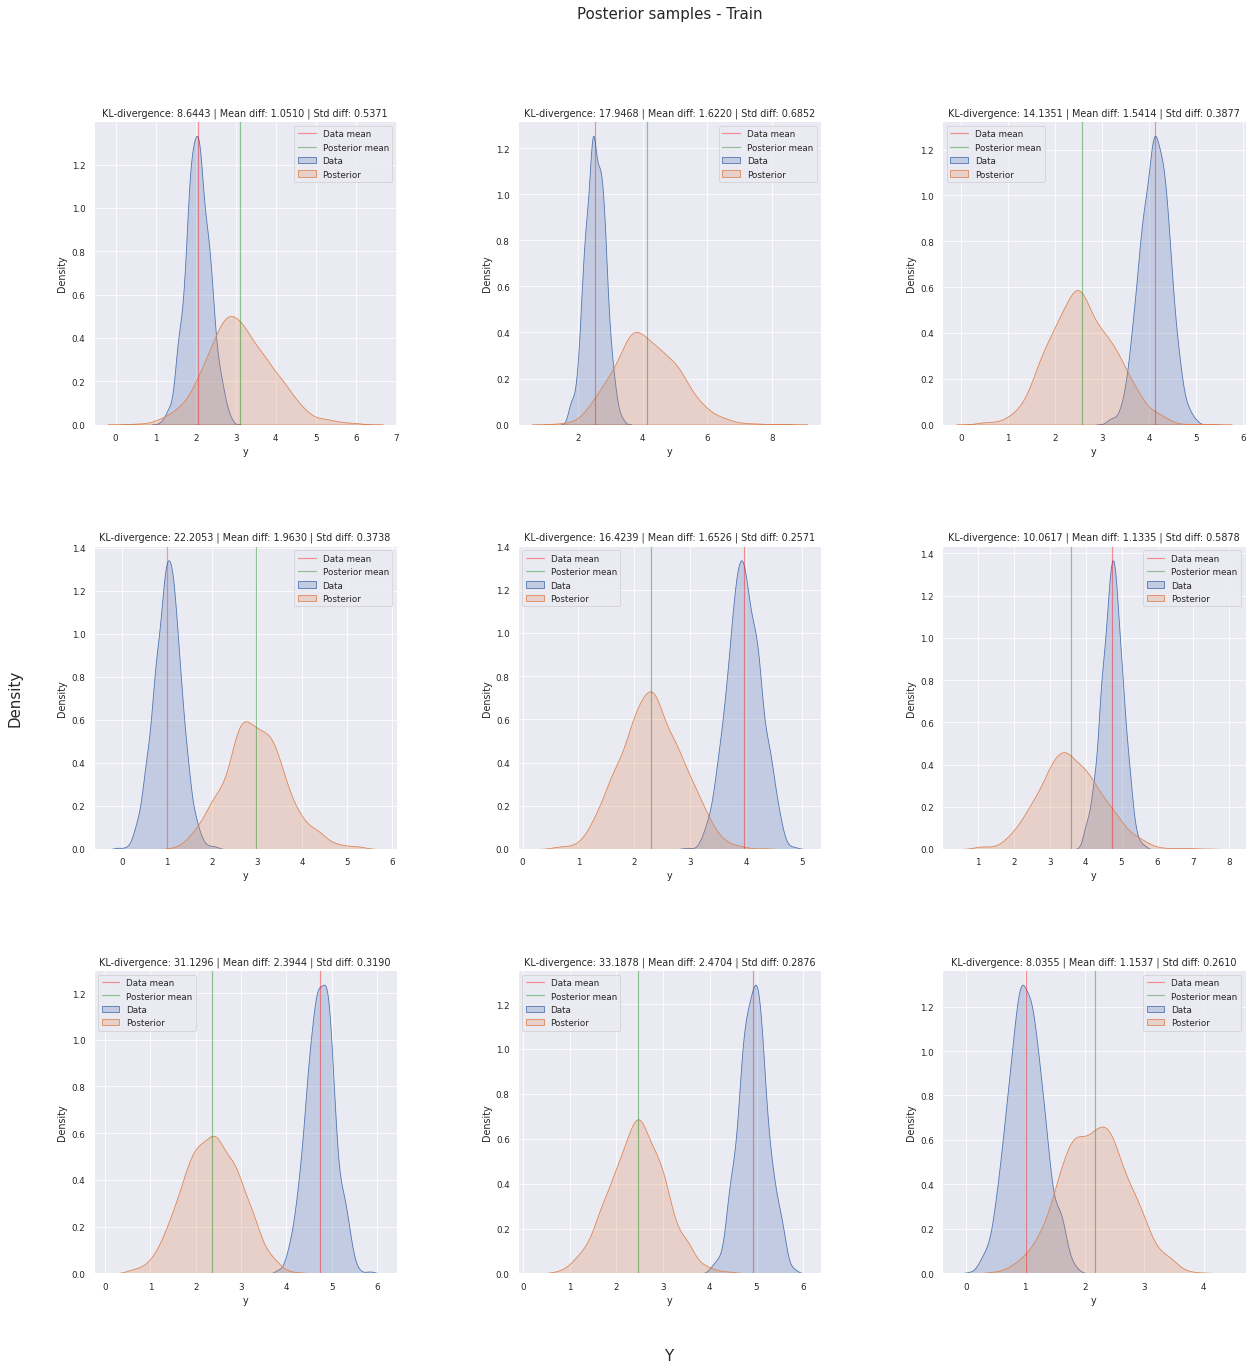

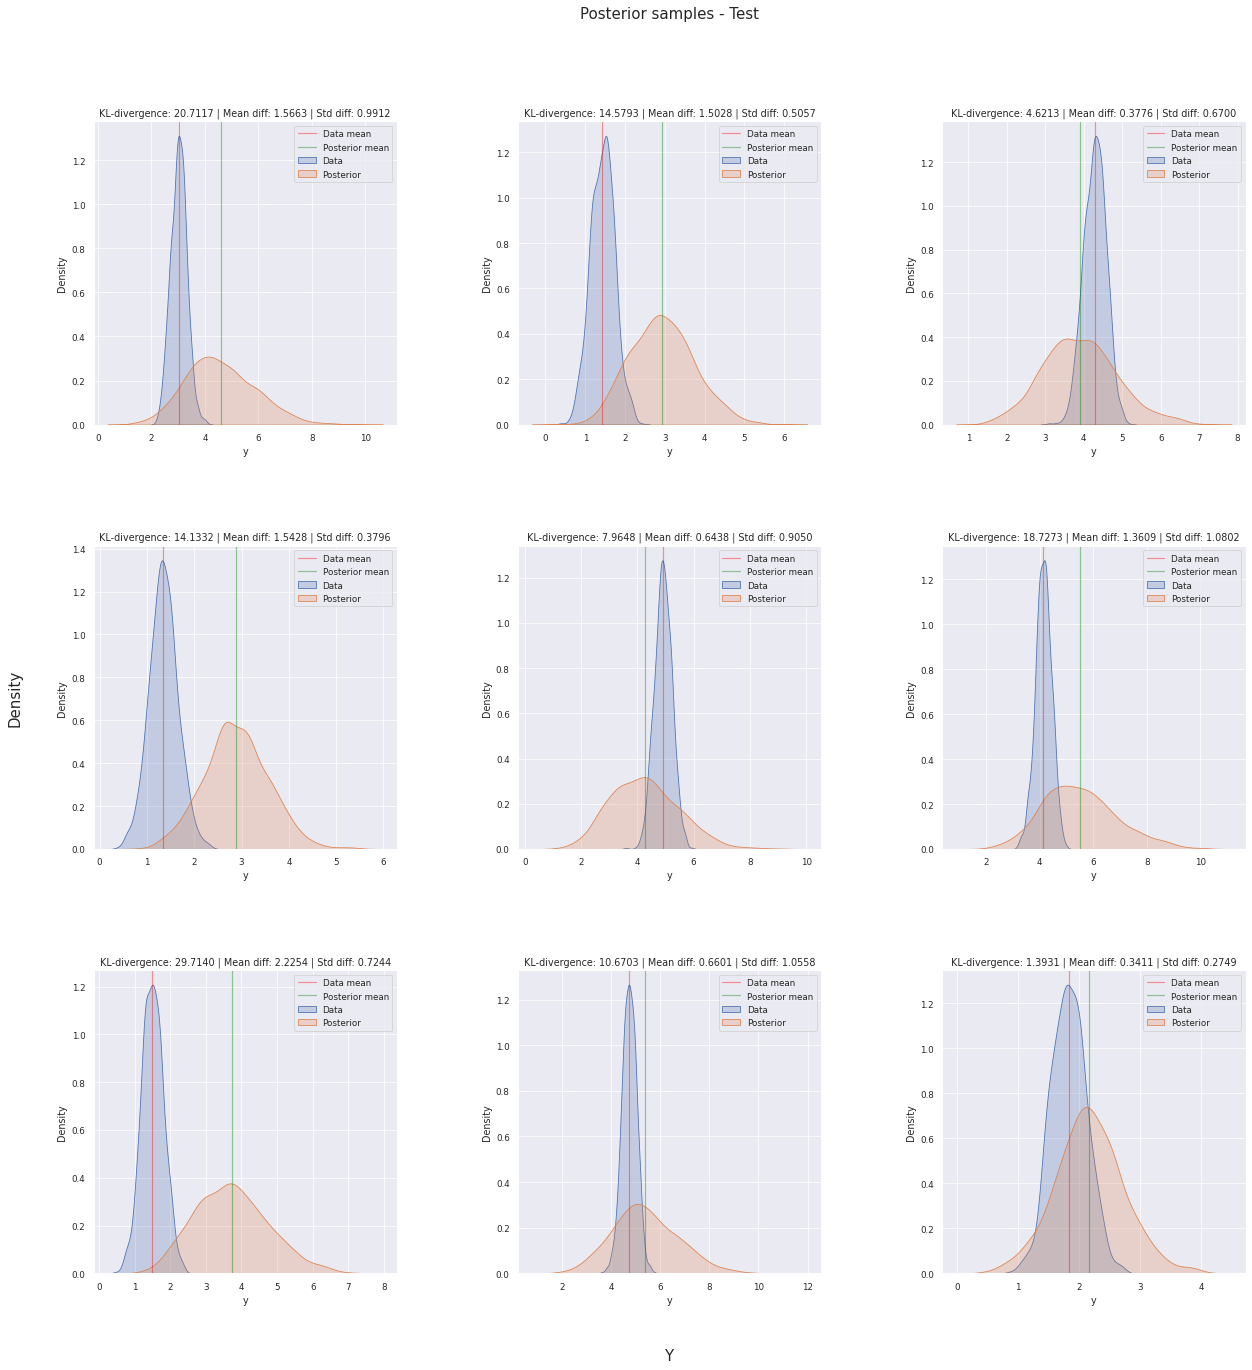

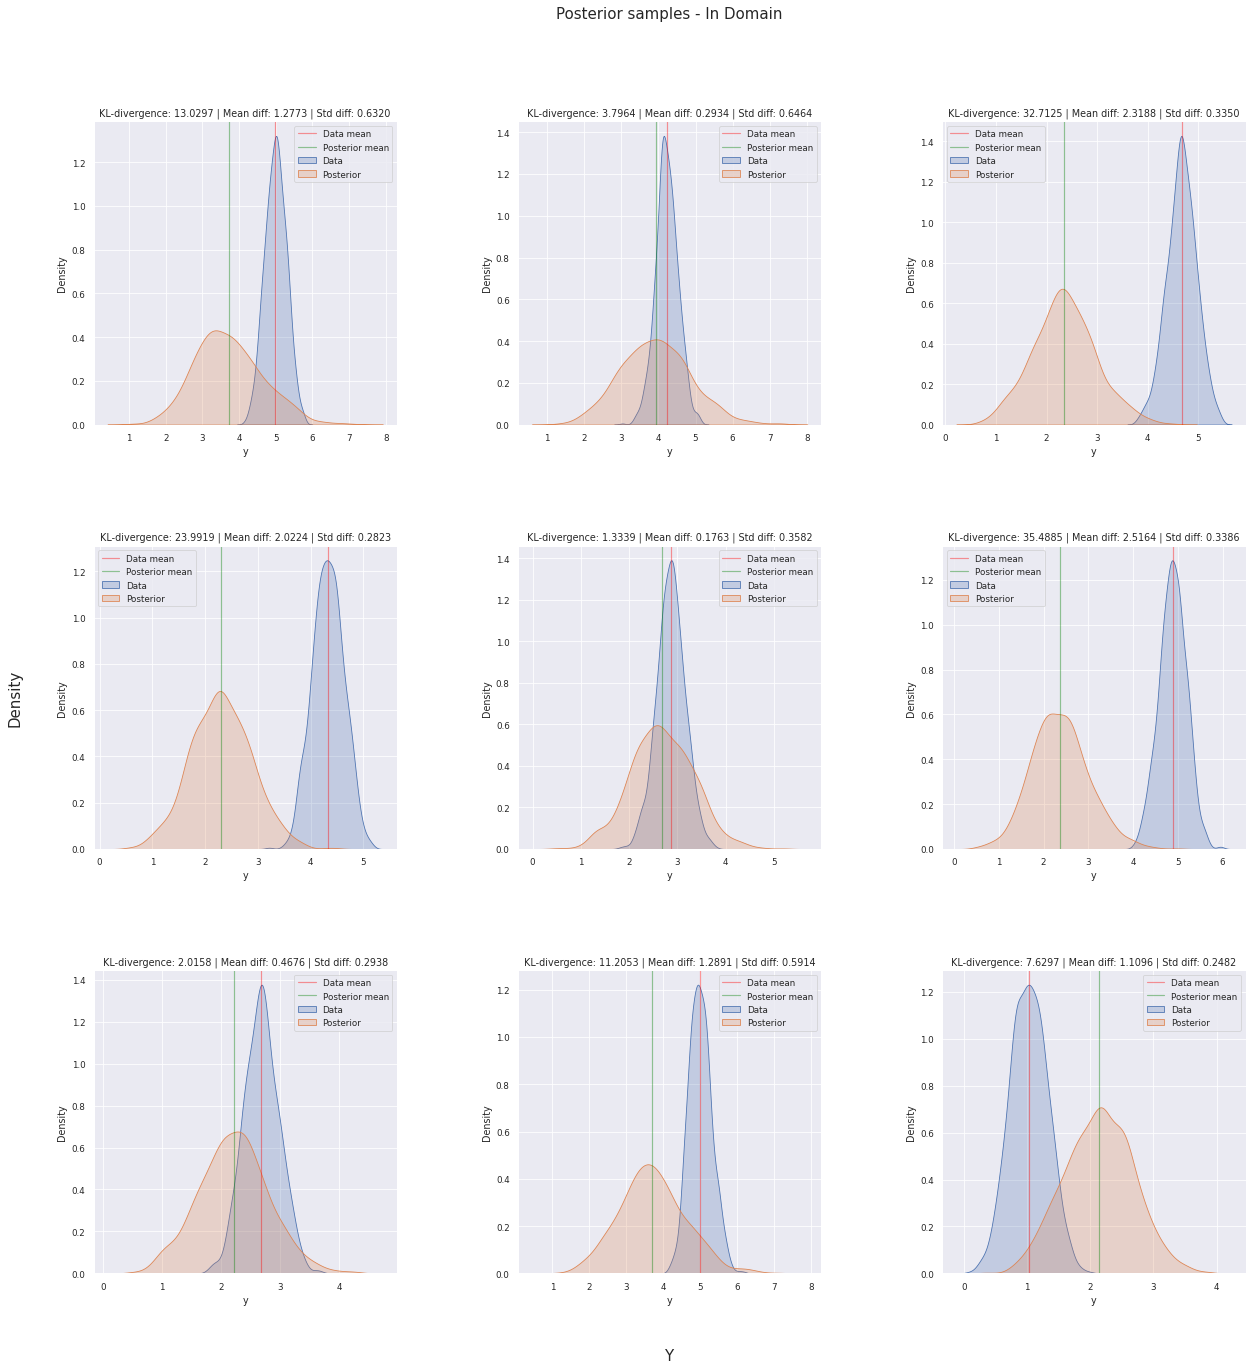

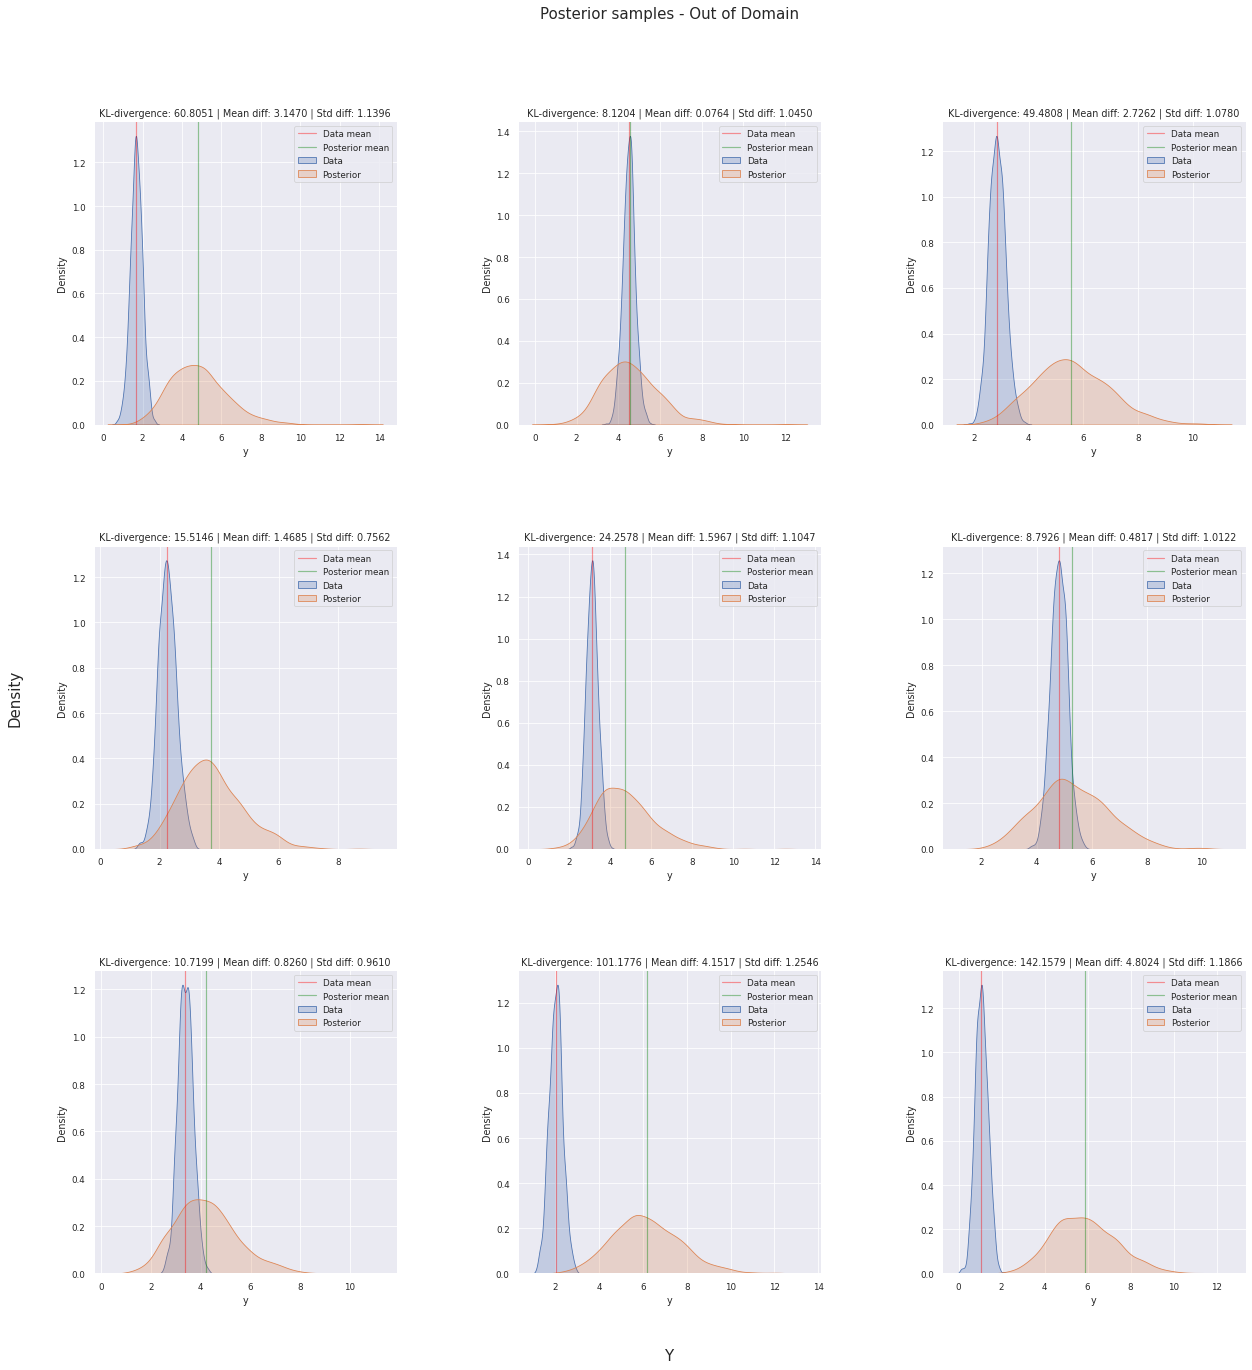

Eval done in 0:00:20.208396


In [ ]:
if True:
            if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")

            eval.eval(config, dataset_config, f"{BASE_DIR}", inference_model=inference_model)

In [ ]:
pyro.get_param_store().get_all_param_names()

dict_keys(['AutoNormal.locs.fc0.weight', 'AutoNormal.scales.fc0.weight', 'AutoNormal.locs.fc0.bias', 'AutoNormal.scales.fc0.bias', 'AutoNormal.locs.fc1.weight', 'AutoNormal.scales.fc1.weight', 'AutoNormal.locs.fc1.bias', 'AutoNormal.scales.fc1.bias', 'AutoNormal.locs.fc2.weight', 'AutoNormal.scales.fc2.weight', 'AutoNormal.locs.fc2.bias', 'AutoNormal.scales.fc2.bias', 'AutoNormal.locs.sigma', 'AutoNormal.scales.sigma'])

In [ ]:
pyro.get_param_store()["AutoGuideList.1.sigma"].shape

KeyError: 'AutoGuideList.1.sigma'